In [18]:
import simpy
import random
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
CONFIG = {
    "total_floors": 100,
    "lobby_floor": 0,
    "num_lifts": 2,
    "occupancy_percent": 1,  # Simulate how full the hotel is
    "guest_arrival_interval": 0.1,  # Base interval between guests
    "sim_duration": 500,  # How long to run the simulation
    "initial_guests": 5
}
MAX_GUESTS = int(CONFIG["total_floors"] * CONFIG["occupancy_percent"] * 10)
wait_times = []

In [20]:
class Hotel:
    def __init__(self, env, num_lifts):
        self.env = env
        self.lift = simpy.Resource(env, num_lifts)

    def travel_time(self, start_floor, end_floor):
        return (abs(end_floor - start_floor) ** 2) / CONFIG["total_floors"]

    def go_to_floor(self, guest, start, end):
        yield self.env.timeout(self.travel_time(start, end))

In [21]:
def guest_process(env, guest_id, hotel):
    arrival_time = env.now
    room_floor = random.randint(1, CONFIG["total_floors"] - 1)
    guest_floor = random.choice([CONFIG["lobby_floor"], room_floor])

    with hotel.lift.request() as request:
        yield request
        if guest_floor == CONFIG["lobby_floor"]:
            yield env.process(hotel.go_to_floor(guest_id, CONFIG["lobby_floor"], room_floor))
        else:
            yield env.process(hotel.go_to_floor(guest_id, room_floor, CONFIG["lobby_floor"]))

    wait_times.append(env.now - arrival_time)
        

In [22]:
def generate_guests(env, hotel):
    guest_id = 0

    # Initial guests
    for _ in range(CONFIG["initial_guests"]):
        env.process(guest_process(env, guest_id, hotel))
        guest_id += 1

    # Dynamic arrivals
    while env.now < CONFIG["sim_duration"] and guest_id < MAX_GUESTS:
        yield env.timeout(CONFIG["guest_arrival_interval"])
        env.process(guest_process(env, guest_id, hotel))
        guest_id += 1

In [23]:
def run_simulation():
    env = simpy.Environment()
    hotel = Hotel(env, CONFIG["num_lifts"])
    env.process(generate_guests(env, hotel))
    env.run(until=CONFIG["sim_duration"])

    if wait_times:
        avg_wait = statistics.mean(wait_times)
        print(f"Average wait time: {avg_wait:.2f} units")
    else:
        print("No guests were processed.")

    # Plot wait time distribution
    sns.histplot(wait_times, bins=20)
    plt.xlabel('Wait Time (units)')
    plt.ylabel('Number of Guests')
    plt.title('Wait Time Distribution')
    plt.grid(True)
    plt.show()


Average wait time: 255.96 units


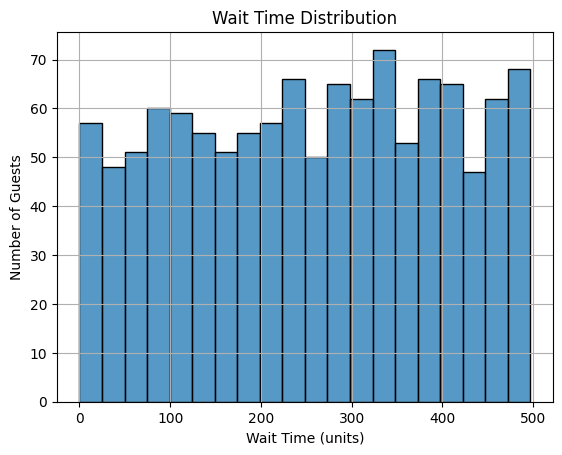

In [61]:
if __name__ == "__main__":
    run_simulation()
